# Lab 7 & 8
Lucas Street, 1874989

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
from hera_cal.io import HERAData

In [45]:
filename = '../Lab 5/zen.2458108.57290.HH.uvh5'
hd = HERAData(filename)

def get_spectrogram(hd, selected_times, freq_channels, *args, read_args={}, filter_dupes=False, **kwargs):
    hd.read(times=selected_times, freq_chans=freq_channels, **read_args)
    if filter_dupes:
        pairs = np.array(hd.get_antpairs())
        no_dupe_pairs = pairs[pairs[:, 0] != pairs[:, 1]]
        hd.select(bls=list(map(tuple, no_dupe_pairs)))
    data = hd.get_data(*args, **kwargs)
    times = hd.get_times(*args, **kwargs)
    times -= times[0]
    freqs_mhz = hd.freq_array.flatten() / 1e6
    return pd.DataFrame(data, times, freqs_mhz), times, freqs_mhz

def plot_spectrogram(freqs, times, data, colorbar=True):
    # Handle case where we only have one unique time
    single_time = False
    if times[0] == times[-1]:
        single_time = True
        times = [0, 1]
    
    plt.imshow(np.abs(data), origin='bottom', extent=(freqs[0], freqs[-1], times[0], times[-1]), aspect='auto')
    
    if single_time:
        # No need for a time axis if we only have one time
        plt.gca().get_yaxis().set_visible(False)
    
    plt.ylabel('$\Delta t$ (JD)')
    plt.xlabel('Frequency (MHz)')
    if colorbar:
        cbar = plt.colorbar()
        cbar.set_label('Amplitude')
    
def plot_avg_amplitudes(freqs, times, data):
    avg_amplitudes = np.mean(np.abs(data), axis=0)
    plt.plot(freqs, avg_amplitudes)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Amplitude')
    plt.xlim(freqs[0], freqs[-1])
    
def plot_histogram(times, frequency_channels, max_amplitude=0.4, nbins=100, width_mul=1, polarization='XX'):
    all_antenna_data, _, _ = get_spectrogram(hd, times, frequency_channels, polarization)
    hist_data = np.abs(np.array(all_antenna_data).flatten())
    hist_data = hist_data[np.abs(hist_data) < max_amplitude]
    # print(len(hist_data))
    hist, edges = np.histogram(hist_data, bins=nbins, density=True)
    plt.title(f"Background distribution for time {times.round(4)}")
    plt.xlabel('Amplitude')
    plt.ylabel('Probability Density')
    plt.bar(edges[:-1], hist, width=width_mul*(edges[1] - edges[0]))
    return hist_data

def plot_lognormal_fit(hist_data, max_amplitude=0.4, *args, **kwargs):
    sigma, mean, scale = stats.lognorm.fit(hist_data)
    dist = stats.lognorm(sigma, mean, scale)
    x = np.linspace(0, max_amplitude, 1000)
    y = dist.pdf(x)
    plt.plot(x, y, *args, **kwargs)
    plt.yscale('log')
    plt.xlim(0, max_amplitude)
    plt.ylim(1e-4)
    plt.legend(['Lognormal fit', 'Background'])
    print(f"Lognormal: mu: {mean}, sigma: {sigma}, s: {scale}")
    return sigma, mean, scale

## Signal Removal

In [46]:
np.sort(hd.antenna_numbers)

array([  0,   1,   2,  11,  12,  13,  14,  23,  24,  25,  26,  27,  36,
        37,  38,  39,  40,  41,  50,  51,  52,  53,  54,  55,  65,  66,
        67,  68,  69,  70,  71,  82,  83,  84,  85,  86,  87,  88,  98,
       120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143])

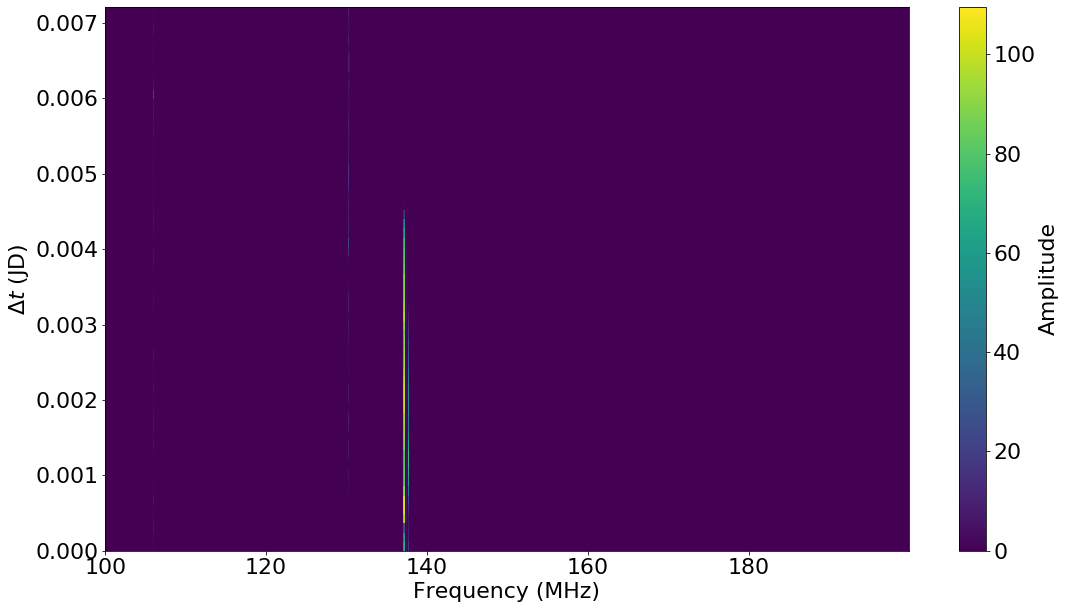

In [75]:
data, times, freqs_mhz = get_spectrogram(hd, hd.times[0:], np.arange(0, 1024), 'XX', read_args={'bls': [(1, 124)]}, filter_dupes=False)
data = np.diff(data, axis=0)
times = times[:-1]
plot_spectrogram(freqs_mhz, times, data)

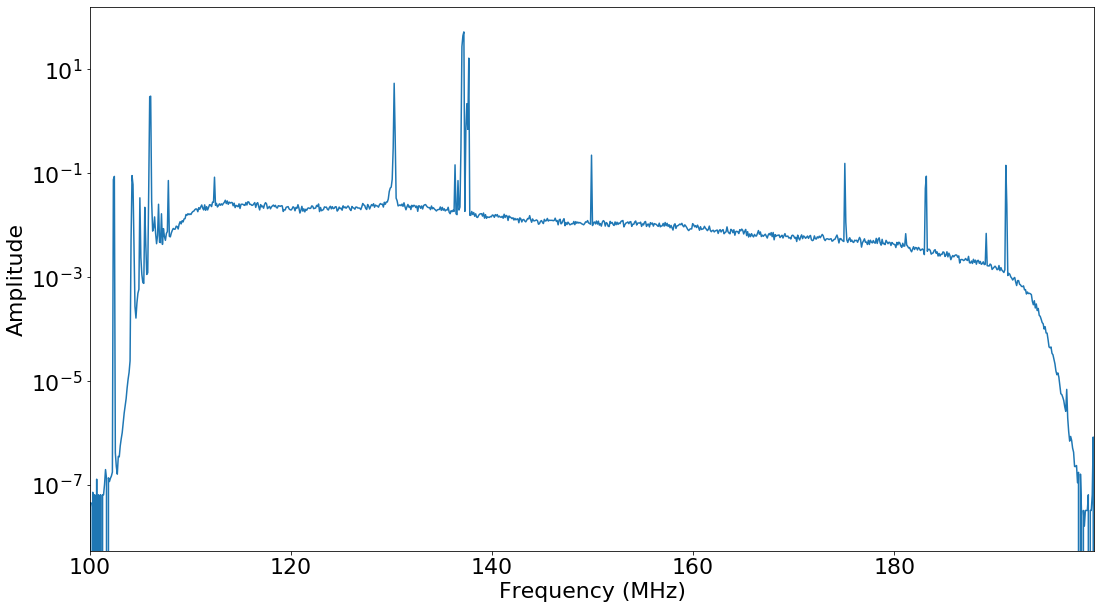

In [76]:
plot_avg_amplitudes(freqs_mhz, times, data)
plt.yscale('log')

34565
Lognormal: mu: -0.0017742591781316308, sigma: 0.6388091155745583, s: 0.012134590932748669


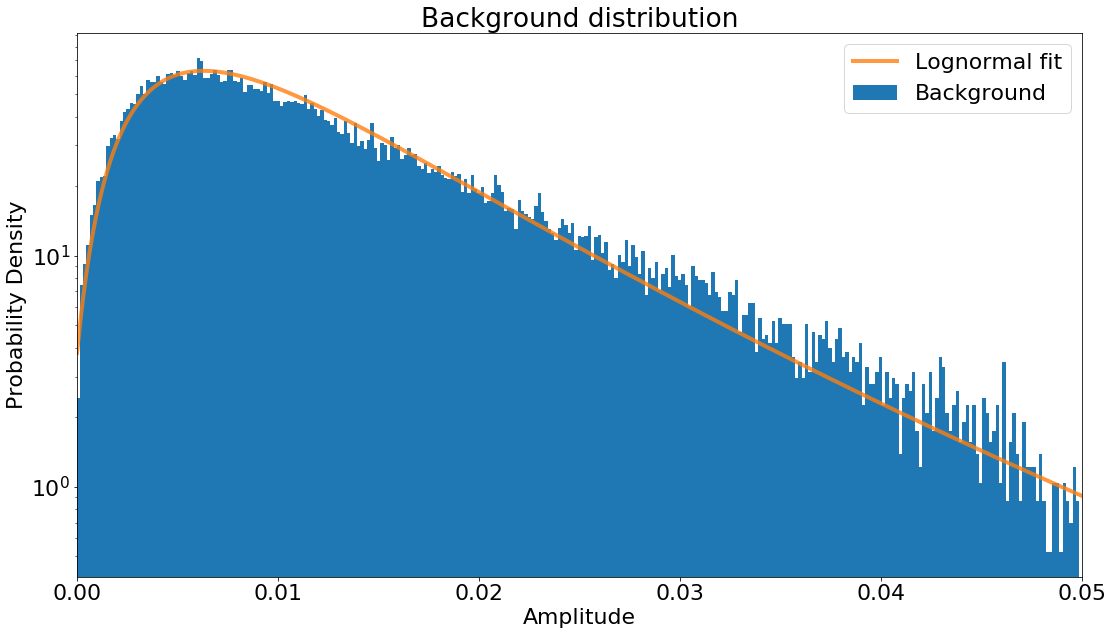

In [87]:
max_amplitude = 0.05
hist_data = np.abs(data[:, 200:800]).flatten()
hist_data = hist_data[hist_data < max_amplitude]
print(len(hist_data))
hist, edges = np.histogram(hist_data, bins=300, density=True)

plt.title(f"Background distribution")
plt.xlabel('Amplitude')
plt.ylabel('Probability Density')
plt.bar(edges[:-1], hist, width=edges[1] - edges[0])
plt.yscale('log')

sigma, mean, scale = stats.lognorm.fit(hist_data)
dist = stats.lognorm(sigma, mean, scale)
x = np.linspace(0, max_amplitude, 1000)
y = dist.pdf(x)
plt.plot(x, y, 'C1', linewidth=4, alpha=0.8)
plt.yscale('log')
plt.xlim(0, max_amplitude)
plt.legend(['Lognormal fit', 'Background'])
print(f"Lognormal: mu: {mean}, sigma: {sigma}, s: {scale}")

In [186]:
data, times, freqs_mhz = get_spectrogram(hd, hd.times[0:8], np.arange(0, 1024), 'XX', filter_dupes=True)
num_times = len(set(times))
num_baselines = data.shape[0] // num_times
data = np.dstack(np.split(np.array(data), num_times))
data = np.diff(data, axis=2)
times = times[:-1]
average_amplitudes = np.transpose(np.mean(np.abs(data), axis=0))

In [202]:
average_amplitudes.shape

(7, 1024)

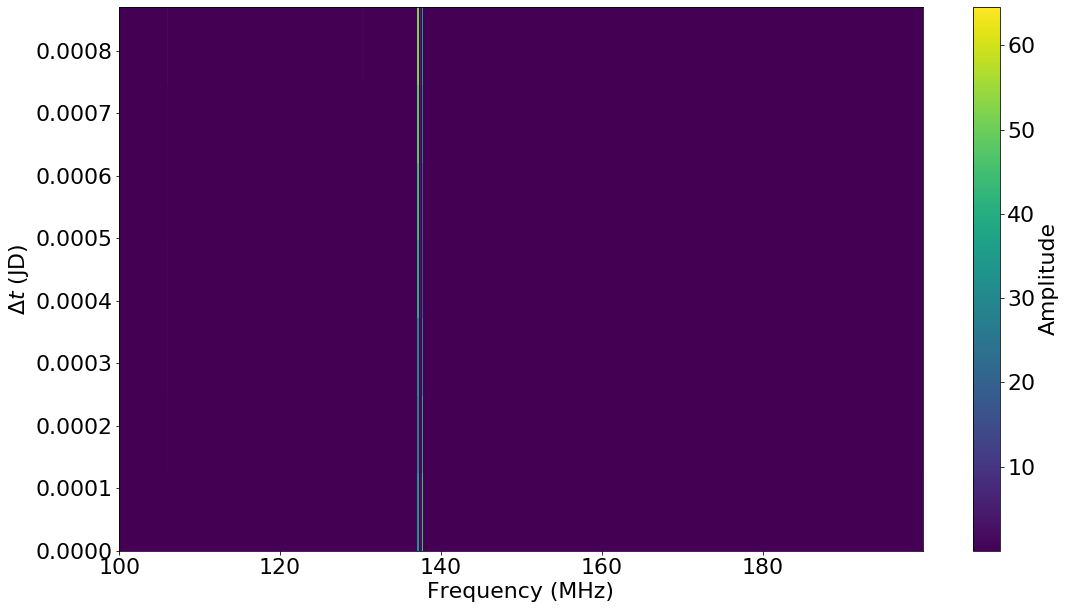

In [187]:
plot_spectrogram(freqs_mhz, times, average_amplitudes)

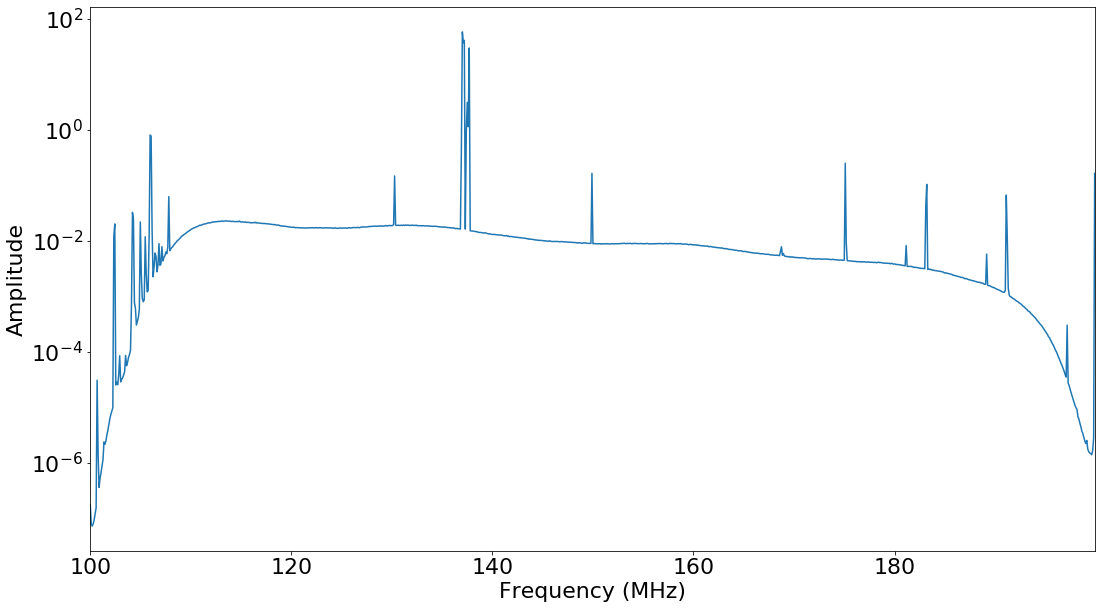

In [188]:
plot_avg_amplitudes(freqs_mhz, times, average_amplitudes)
plt.yscale('log')

7046


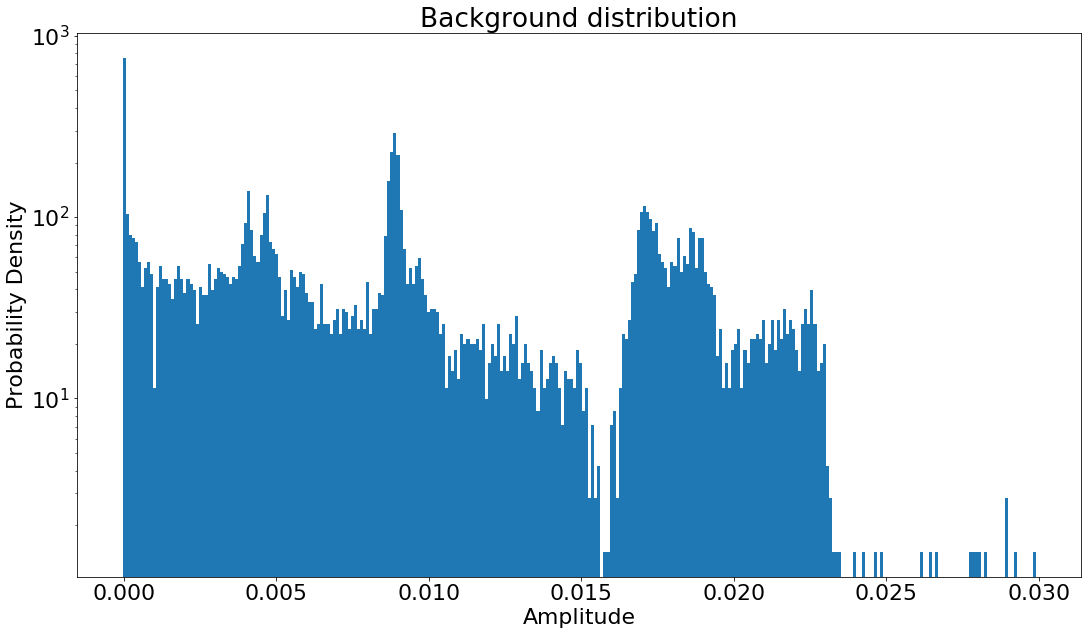

In [222]:
max_amplitude = 0.03
hist_data = np.abs(average_amplitudes).flatten()
hist_data = hist_data[hist_data < max_amplitude]
print(len(hist_data))
hist, edges = np.histogram(hist_data, bins=300, density=True)

plt.title(f"Background distribution")
plt.xlabel('Amplitude')
plt.ylabel('Probability Density')
plt.bar(edges[:-1], hist, width=edges[1] - edges[0])
plt.yscale('log')

# sigma, mean, scale = stats.lognorm.fit(hist_data[0:500_000])
# dist = stats.lognorm(sigma, mean, scale)
# x = np.linspace(0, max_amplitude, 1000)
# y = dist.pdf(x)
# plt.plot(x, y, 'C1', linewidth=4, alpha=0.8)
# plt.yscale('log')
# plt.legend(['Lognormal fit', 'Background'])
# print(f"Lognormal: mu: {mean}, sigma: {sigma}, s: {scale}")